In [208]:
import torch
import torch.nn as nn
from torch.func import vmap, jacrev, functional_call
from torch.optim import SGD

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [209]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(2):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

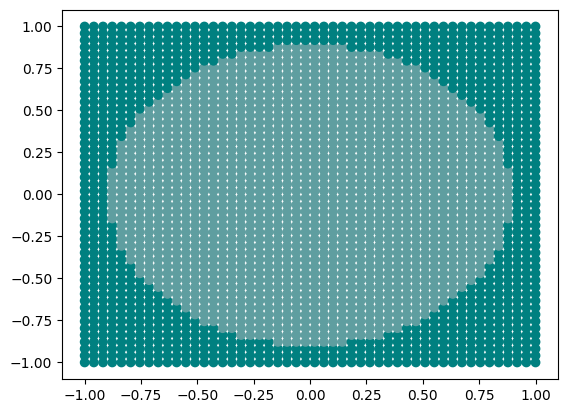

In [210]:
RES=50
X=[]
for x_1 in np.linspace(-1,1,RES):
    for x_2 in np.linspace(-1,1,RES):
        X.append([x_1,x_2])
X=np.array(X)

encode_inputs=lambda x: 1 if x[0]**2+x[1]**2<np.sqrt(2/np.pi) else 0
y=np.array([encode_inputs(x) for x in X])


X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

colors=np.full(len(y), 'cadetblue')
colors[y==0]='teal'

plt.scatter(X[:,0],X[:,1],c=colors)

In [211]:
def network_parameters(model):
    parameters=[]
    for para in model.named_parameters():
        if 'weight' in para[0]:
            for l in para[1]:
                parameters+=l.tolist()
        else:
            parameters+=para[1].tolist()
    return np.array(parameters)

In [212]:
def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

BATCH_SIZE = 100
EPOCHS = 200
LR = 0.05

def training(model):
	trainAcc = 0
	samples_train = 0
	weights_prior=network_parameters(model).copy()
	model.train()
	for (batchX, batchY) in next_batch(X, y, BATCH_SIZE):
		predictions = model(batchX)
		loss = lossFunc(predictions, batchY.long())
		opt.zero_grad()
		loss.backward()
		opt.step()
		trainAcc += (predictions.max(1)[1] == batchY).sum().item()
                
		samples_train+=len(batchY)
                
	weights_after=network_parameters(model).copy()
	return model,loss.item(), trainAcc/samples_train, norm(weights_after-weights_prior,ord=2)

In [213]:
def tangent_feature_matrix(model, X, y):
    feature_matrix=[]
    for batchX, batchY in next_batch(X,y,1):
        model.zero_grad()
        y=model(batchX)
        y.backward(torch.ones_like(y), retain_graph=True)
        gradient=[]
        gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
        gradient+=model.input_layer.bias.grad.tolist()
        gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
        gradient+=model.output_layer.bias.grad.tolist()
        for layer in model.hidden:
            gradient+=torch.flatten(layer.weight.grad).tolist()
            gradient+=layer.bias.grad.tolist()
        feature_matrix.append(np.array(gradient))
    return np.transpose(feature_matrix)

In [216]:
norm_complexities=[]
parameter_count=[]
for k in range(5):
    complexity=[0]
    epoch_list=[0]
    l=1
    n=1
    model = NeuralNet(2,2**(k+3),2)
    ReLU_glorot_init(model)
    opt = SGD(model.parameters(), lr=LR)
    lossFunc = nn.CrossEntropyLoss()
    while l>0.01:
        model,l,train_a, param_update=training(model)
        params=dict(model.named_parameters())
        J=tangent_feature_matrix(model, X, y)
        complexity.append(complexity[-1]+param_update*norm(J))
        epoch_list.append(n)
        print('Epoch {}: Loss {}, Training Accuracy {:.3f}, Complexity: {:.3f}'.format(n,l,train_a,complexity[-1]))
        n+=1
    hidden_size=2**(k+3)
    parameter_count.append(2*hidden_size+hidden_size+2*(hidden_size**2+hidden_size)+2*hidden_size+2)
    norm_complexities.append(complexity[-1]/parameter_count[-1])

Epoch 1: Loss 0.6837618947029114, Training Accuracy 0.638, Complexity: 49.716
Epoch 2: Loss 0.6913971900939941, Training Accuracy 0.679, Complexity: 80.317
Epoch 3: Loss 0.6337745785713196, Training Accuracy 0.715, Complexity: 112.898
Epoch 4: Loss 0.5276799201965332, Training Accuracy 0.742, Complexity: 152.199
Epoch 5: Loss 0.4389971196651459, Training Accuracy 0.785, Complexity: 195.093
Epoch 6: Loss 0.3567066490650177, Training Accuracy 0.794, Complexity: 240.830
Epoch 7: Loss 0.28470250964164734, Training Accuracy 0.814, Complexity: 289.069
Epoch 8: Loss 0.2298557460308075, Training Accuracy 0.838, Complexity: 340.180
Epoch 9: Loss 0.18749786913394928, Training Accuracy 0.863, Complexity: 394.180
Epoch 10: Loss 0.15493841469287872, Training Accuracy 0.882, Complexity: 451.847
Epoch 11: Loss 0.12491629272699356, Training Accuracy 0.900, Complexity: 509.593
Epoch 12: Loss 0.10236208885908127, Training Accuracy 0.910, Complexity: 567.158
Epoch 13: Loss 0.08472812920808792, Training A

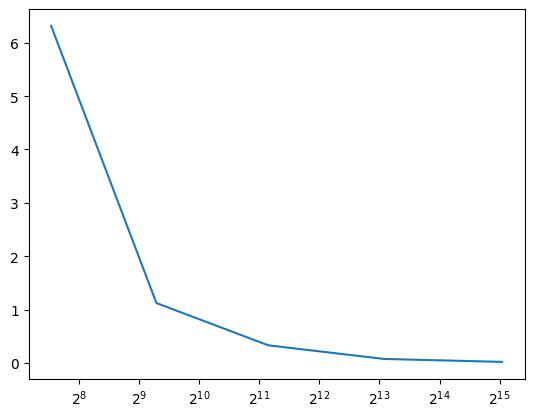

In [217]:
plt.plot(parameter_count, norm_complexities)
plt.xscale('log', base=2)